<h1 align='center'>
<br>
<img src="assets/IBM-Logo.png" alt="IBM Course" width="200">
<br>
    Applied Data Science Capstone
</h1>

<h2 align='center'><font size=5>
    Week 3 Peer-graded Assignment - Segmenting and Clustering Neighborhoods in Toronto | Part III</font>
</h2>


## Scraping Data from Wikipedia

Before starting, let's first import all the libraries needed for the project.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

# showing progress
from tqdm.notebook import tqdm
from tqdm.contrib import tzip

plt.style.use('ggplot') # refined style

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(url)
can_df = tables[0]

In [3]:
can_df = can_df[~(can_df['Borough'] == 'Not assigned')]
can_df.reset_index(inplace=True)
can_df = can_df.drop('index', 1)

In [4]:
can_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Let's make sure that postal code appears only once in the entire data set.

In [5]:
len(set(can_df['Postal Code'])) == len(can_df['Postal Code'])

True

Also, let's check if there is still `Not assigned` neighborhood.

In [6]:
can_df[can_df['Neighbourhood']== 'Not assigned'].shape[0]

0

Notice that among all those 103 neighborhoods, some of them are duplicated.

In [7]:
can_df.shape

(103, 3)

## Adding Latitude and Longtitude

In [8]:
geo_data = pd.read_csv('assets/Geospatial_Coordinates.csv')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
tor_df = can_df.merge(geo_data, on='Postal Code')
tor_df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
tor_df.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [10]:
len(tor_df.Neighborhood.unique())

99

## Exploring and Clustering the Neighborhoods in Toronto

### Checking Out the Neighborhoods

In [11]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6534817 -79.3839347


In [12]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

### Define Foursquare Credentials and Version

### Exploring Neiborhoods in Toronto

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    
    for name, lat, lng in tzip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = pd.DataFrame()
toronto_venues = getNearbyVenues(np.asarray(tor_df.Neighborhood), np.asarray(tor_df.Latitude), np.asarray(tor_df.Longitude), 500)
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Notice that we might have some neighborhoods that don't have enough exploration sights. 

In [18]:
len(toronto_venues.Neighborhood.unique())

96

In [19]:
print(toronto_venues.shape)
toronto_venues.groupby('Neighborhood').count()

(2118, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


#### Analyzing Each Neighborhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
nei_index = list(toronto_onehot.columns).index("Neighborhood")
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[nei_index]] + (list(toronto_onehot.columns[:nei_index]) + list(toronto_onehot.columns[nei_index + 1:]))
toronto_onehot.head()
toronto_onehot = toronto_onehot[fixed_columns]
# # display(fixed_columns)

toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
len(toronto_onehot.Neighborhood.unique())

96

In [23]:
print(toronto_onehot.shape)

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

(2118, 271)


,Neighborhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.

In [24]:
toronto_grouped.shape

(96, 271)

In [25]:
num_top_venues = 5

for hood in tqdm(toronto_grouped['Neighborhood']):
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1             Clothing Store   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4               Skating Rink   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1        Pharmacy  0.12
2             Gym  0.12
3             Pub  0.12
4  Sandwich Place  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.09
1                       Bank  0.09
2                Pizza Place  0.05
3  Middle Eastern Restaurant  0.05
4                   Pharmacy  0.05


----Bayview Village----
                     venue  freq
0      Japanese Restaurant  0.25
1                     Café  0.25
2       Chinese Restaurant  0.25
3                     Bank  0.25
4  New American Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1  

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [119]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
display(neighborhoods_venues_sorted.head())

(96, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Clothing Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pub,Sandwich Place,Gym,Pharmacy,Eastern European Restaurant,Dumpling Restaurant,Drugstore
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Frozen Yogurt Shop,Bridal Shop,Shopping Mall,Sandwich Place,Diner,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Comfort Food Restaurant,Restaurant,Butcher,Sushi Restaurant,Indian Restaurant,Juice Bar,Pub


### Clustering Neighborhoods

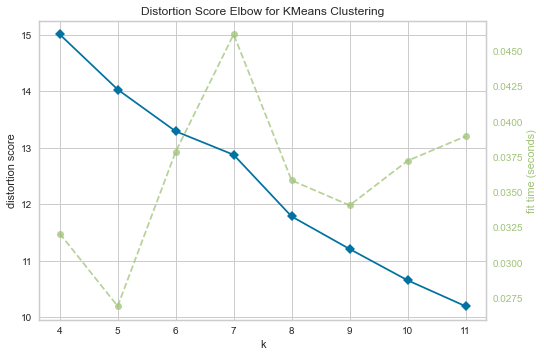

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(4, 12), locate_elbow=False)
visualizer.fit(toronto_grouped_clustering)
visualizer.show()

In [120]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

[0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 7 5 0 0 0 0 0 0 4 0 0 3 4 0 0 0 0 0 0 0 5 0 0 4 0 0 0 4 6 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 6 0 0 0 0 0 0 1 0 4 0 0 0 0 4]


In [121]:
tor_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [122]:
tor_df.shape

(103, 5)

In [123]:
toronto_merged = tor_df.copy()

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
if (toronto_merged.isnull().sum().any()):
    toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(kclusters)
    kclusters += 1
toronto_merged.drop('Postal Code', 1, inplace=True)
toronto_merged.head(6) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,4.0,Food & Drink Shop,Park,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
1,North York,Victoria Village,43.725882,-79.315572,0.0,Pizza Place,Portuguese Restaurant,French Restaurant,Hockey Arena,Coffee Shop,Intersection,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Park,Restaurant,Theater,Breakfast Spot,Café,Pub,Distribution Center,Chocolate Shop
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Furniture / Home Store,Event Space,Coffee Shop,Miscellaneous Shop,Boutique,Accessories Store,Vietnamese Restaurant,Eastern European Restaurant,Electronics Store
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Gym,Sushi Restaurant,Yoga Studio,Japanese Restaurant,Mexican Restaurant,Bar,Bank,Café,Diner
5,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
toronto_merged.shape

(103, 15)

In [125]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters) # adding one more since we are containing neighborhoods with missing places 
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

In [126]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, max_depth=10, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=0) # min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level
    # criterion="entropy", max_depth = 4
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])
    return report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']]

In [127]:
cr = cluster_report(toronto_grouped_clustering, neighborhoods_venues_sorted['Cluster Labels'], min_samples_leaf=1, pruning_level=0.5, max_depth=5)
cr.loc[8] = [8, sum(toronto_merged['Cluster Labels'] == 8), 'None']

,class_name,instance_count,rule_list
0,0,80,[0.975609756097561] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground <= 0.5108695654198527) and (Furniture / Home Store <= 0.3333333358168602)
7,1,1,NaN
6,2,1,[1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground > 0.5108695654198527)
5,3,1,NaN
1,4,8,[1.0] (Park > 0.2916666716337204)
3,5,2,[1.0] (Park <= 0.2916666716337204) and (Baseball Field > 0.2884615398943424)
2,6,2,[1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool > 0.3500000014901161)
4,7,1,[1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground <= 0.5108695654198527) and (Furniture / Home Store > 0.3333333358168602)


In [128]:
for num in range(0, kclusters):
    result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
    print(result)

=== Cluster 1 ===
Instance count: 80
Rule: [0.975609756097561] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground <= 0.5108695654198527) and (Furniture / Home Store <= 0.3333333358168602)


=== Cluster 2 ===
Instance count: 1
Rule: nan
=== Cluster 3 ===
Instance count: 1
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground > 0.5108695654198527)


=== Cluster 4 ===
Instance count: 1
Rule: nan
=== Cluster 5 ===
Instance count: 8
Rule: [1.0] (Park > 0.2916666716337204)


=== Cluster 6 ===
Instance count: 2
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field > 0.2884615398943424)


=== Cluster 7 ===
Instance count: 2
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool > 0.3500000014901161)


=== Cluster 8 ===
Instance count: 1
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.

#### Cluster 1

In [129]:
num = 0
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Pizza Place,Portuguese Restaurant,French Restaurant,Hockey Arena,Coffee Shop,Intersection,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Restaurant,Theater,Breakfast Spot,Café,Pub,Distribution Center,Chocolate Shop
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Furniture / Home Store,Event Space,Coffee Shop,Miscellaneous Shop,Boutique,Accessories Store,Vietnamese Restaurant,Eastern European Restaurant,Electronics Store
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Gym,Sushi Restaurant,Yoga Studio,Japanese Restaurant,Mexican Restaurant,Bar,Bank,Café,Diner
7,Don Mills,Gym,Beer Store,Restaurant,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Italian Restaurant,Discount Store,Sporting Goods Shop


=== Cluster 1 ===
Instance count: 80
Rule: [0.975609756097561] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground <= 0.5108695654198527) and (Furniture / Home Store <= 0.3333333358168602)




#### Cluster 2

In [130]:
num = 1
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Weston,Jewelry Store,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Field


=== Cluster 2 ===
Instance count: 1
Rule: nan


#### Cluster 3

In [131]:
num = 2
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough Village,Playground,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


=== Cluster 3 ===
Instance count: 1
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground > 0.5108695654198527)




#### Cluster 4

In [132]:
num = 3
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern, Rouge",Fast Food Restaurant,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore


=== Cluster 4 ===
Instance count: 1
Rule: nan


#### Cluster 5

In [133]:
num = 4
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Food & Drink Shop,Park,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
21,Caledonia-Fairbanks,Park,Women's Store,Pool,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
35,"East Toronto, Broadview North (Old East York)",Park,Pizza Place,Convenience Store,Intersection,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
52,"Willowdale, Newtonbrook",Park,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
61,Lawrence Park,Bus Line,Park,Swim School,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


=== Cluster 5 ===
Instance count: 8
Rule: [1.0] (Park > 0.2916666716337204)




#### Cluster 6

In [134]:
num = 5
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,"Humberlea, Emery",Food Service,Baseball Field,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio,Diner
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Baseball Field,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Field


=== Cluster 6 ===
Instance count: 2
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field > 0.2884615398943424)




#### Cluster 7

In [135]:
num = 6
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Roselawn,Garden,Pool,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
98,"The Kingsway, Montgomery Road, Old Mill North",River,Pool,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


=== Cluster 7 ===
Instance count: 2
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool > 0.3500000014901161)




#### Cluster 8

In [136]:
num = 7
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Humber Summit,Intersection,Furniture / Home Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Fast Food Restaurant


=== Cluster 8 ===
Instance count: 1
Rule: [1.0] (Park <= 0.2916666716337204) and (Baseball Field <= 0.2884615398943424) and (Pool <= 0.3500000014901161) and (Playground <= 0.5108695654198527) and (Furniture / Home Store > 0.3333333358168602)




#### Cluster 9

In [137]:
num = 8
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == num, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head())
result = f"""=== Cluster {num + 1} ===
Instance count: {cr.iloc[num, 1]}
Rule: {cr.iloc[num, 2]}"""
print(result)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Islington Avenue, Humber Valley Village",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,"York Mills, Silver Hills",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Upper Rouge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== Cluster 9 ===
Instance count: 3
Rule: None
